# Исследование воронки продаж и результатов А/В-теста

В ходе данного проекта будет исследована воронка продаж, выявлено, на каких шагах теряется больше всего пользователей.

Также будут изучены результаты A/A/B-эксперимента относительно изменения поведения пользователей после изменения дизайна приложения.

## Выгрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math as mth

In [ ]:
# сохраним датасет в переменную data и выведем первые строки на экран
data = pd.read_csv('logs_exp.csv')
data.head()

,EventName\tDeviceIDHash\tEventTimestamp\tExpId
0,MainScreenAppear\t4575588528974610257\t1564029...
1,MainScreenAppear\t7416695313311560658\t1564053...
2,PaymentScreenSuccessful\t3518123091307005509\t...
3,CartScreenAppear\t3518123091307005509\t1564054...
4,PaymentScreenSuccessful\t6217807653094995999\t...


In [ ]:
# разделим столбцы в data и выведем первые строки на экран
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовка данных

### Переименование столбцов

In [ ]:
# переименуем столбцы data
data.columns = ['event_type', 'user_id', 'timestamp', 'group']
data.head()

,event_type,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Обработка пропусков

In [ ]:
# выведем на экран информацию о data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_type  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   timestamp   244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нет.

### Добавление столбцов

In [ ]:
# добавим в data столбец с датой и временем, а также столбец с датой
data['date_time'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')
data.head()

,event_type,user_id,timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Обработка дубликатов

In [ ]:
# найдём количество строк-дубликатов в data
data.duplicated().sum()

413

In [ ]:
# удалим строки-дубликаты из data
data = data.drop_duplicates()
data.duplicated().sum()

0

Строки-дубликаты удалены.

In [ ]:
# проверим, есть ли пользователи, состоящие в нескольких группах,
# для этого найдём для каждого пользователя количество групп, в которых он состоит
t1 = data.pivot_table(index='user_id', values='group', aggfunc='nunique')
t1.columns = ['groups_amount']

# найдём пользователей, состоящих более, чем в одной группе
t1 = t1[t1['groups_amount'] > 1]
t1

,groups_amount
user_id,


Пользователей, состоящих в нескольких группах, нет.

## Проверка данных

In [ ]:
# найдём количество событий в data
data['event_type'].count()

243713

Всего 243713 событий.

In [ ]:
# найдём количество пользователей в data
data['user_id'].nunique()

7551

Всего 7551 пользователей.

In [ ]:
# найдём среднее количество событий на пользователя
round(data['event_type'].count() / data['user_id'].nunique(), 2)

32.28

На одного пользователя в среднем приходится 32.33 события.

In [ ]:
# найдём минимальную и максимальную дату событий
display(data['date'].min())
data['date'].max()

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

В логе имеются данные за период с 25 июля по 7 августа 2019 года.

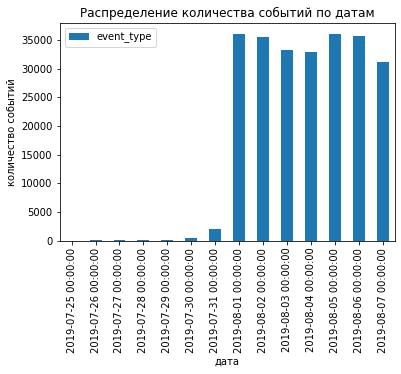

In [ ]:
# построим столбчатую диаграмму распределения событий по датам
data.pivot_table(index='date', values='event_type', aggfunc='count').plot(kind='bar')

plt.title('Распределение количества событий по датам')
plt.xlabel('дата')
plt.ylabel('количество событий')
plt.show()

Для целей исследования следует удалить данные, полученные раньше 1 августа 2019 года.

In [ ]:
# сохраним очищенные данные в переменную data_pure и выведем информацию о ней на экран
data_pure = data[data['date'] > '2019-07-31 00:00:00']
data_pure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   timestamp   240887 non-null  int64         
 3   group       240887 non-null  int64         
 4   date_time   240887 non-null  datetime64[ns]
 5   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


В результате удаления данных, полученных раньше 1 августа 2019 года, было потеряно 2828 записей, то есть около 1.1% от изначального количества.

In [ ]:
# найдём количество пользователей в data_pure
data_pure['user_id'].nunique()

7534

В результате удаления данных, полученных раньше 1 августа 2019 года, были потеряны данные о 17 пользователях, то есть около 0.02% от изначального количества.

In [ ]:
# проверим, все ли экспериментальные группы сохранились в очищенных данных
data_pure['group'].unique()

array([246, 247, 248])

В результате удаления данных, полученных раньше 1 августа 2019 года, в датафрейме сохранились данные обо всех группах.

## Воронка событий

In [ ]:
# сохраним данные о событиях, их частоте и количестве пользователей, их совершивших, в переменную events
events = data_pure.groupby('event_type', as_index=False).agg({'date_time': 'count', 'user_id': 'nunique'})
events.columns = ['event_type', 'events_amount', 'users_amount']

# отсоритруем events по убыванию частоты
events = events.sort_values(by='events_amount', ascending=False).reset_index(drop=True)
events

,event_type,events_amount,users_amount
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


In [ ]:
# добавим в events столбец с долей пользователей, совершавших событие
events['users_share'] = events['users_amount'] / data_pure['user_id'].nunique()
events

,event_type,events_amount,users_amount,users_share
0,MainScreenAppear,117328,7419,0.984736
1,OffersScreenAppear,46333,4593,0.609636
2,CartScreenAppear,42303,3734,0.495620
3,PaymentScreenSuccessful,33918,3539,0.469737
4,Tutorial,1005,840,0.111495


Предположительно, события в воронке идут в такой последовательности:

1. *MainScreenAppear* (демонстрация главного экрана),
2. *OffersScreenAppear* (демонстрация экрана товаров),
3. *CartScreenAppear* (демонстрация экрана корзины),
4. *PaymentScreenSuccessful* (демонстрация уведомления об успешной оплате).

Исключение, вероятно, составляет событие *Tutorial* (обучение), которое, судя по всему, может быть совершено в любом месте воронки и не является обязательным.

In [ ]:
# удилим из events запись о событии Tutorial
events = events[events['event_type'] != 'Tutorial']
events

,event_type,events_amount,users_amount,users_share
0,MainScreenAppear,117328,7419,0.984736
1,OffersScreenAppear,46333,4593,0.609636
2,CartScreenAppear,42303,3734,0.495620
3,PaymentScreenSuccessful,33918,3539,0.469737


In [ ]:
# добавим в events столбец с долей пользователей, переходящих на следующий шаг с предыдущего
for i in range(0, len(events['event_type'])):
    if i == 0:
        events.loc[i, 'step_share'] = 1
    else:
        events.loc[i, 'step_share'] = events.loc[i, 'users_amount'] / events.loc[i - 1, 'users_amount']

events

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,event_type,events_amount,users_amount,users_share,step_share
0,MainScreenAppear,117328,7419,0.984736,1.000000
1,OffersScreenAppear,46333,4593,0.609636,0.619086
2,CartScreenAppear,42303,3734,0.495620,0.812976
3,PaymentScreenSuccessful,33918,3539,0.469737,0.947777


**Наибольшее количество пользователей теряется при переходе на шаг *OffersScreenAppear*** - около 38.1% пользователей не переходят на этот шаг.

In [ ]:
# найдём долю пользователей, доходящих от первого события до оплаты
events.loc[3, 'users_amount'] / events.loc[0, 'users_amount']

0.47701846610055265

От первого события воронки до оплаты доходят около 47.7% пользователей.

## Результаты эксперимента

### Подготовка тестов

In [ ]:
# сохраним данные о численности групп в переменную groups
groups = data_pure[data_pure['event_type'] != 'Tutorial'].groupby('group', as_index=False).agg({'user_id': 'nunique'})
groups.columns = ['group', 'population']
groups

,group,population
0,246,2483
1,247,2512
2,248,2535


In [ ]:
# сохраним в отдельные переменные данные о численности каждой группы
group_246 = groups.loc[groups['group'] == 246]
group_247 = groups.loc[groups['group'] == 247]
group_248 = groups.loc[groups['group'] == 248]

In [ ]:
# сохраним данные о группе 246 в переменную ex_246
ex_246 = data_pure[(data_pure['event_type'] != 'Tutorial') & (data_pure['group'] == 246)]
ex_246 = ex_246.groupby(['group', 'event_type'], as_index=False).agg({'user_id': ['count', 'nunique']})

ex_246.columns = ['group', 'event_type', 'events_amount', 'users_amount']

ex_246 = ex_246.merge(group_246, on='group', how='left')

ex_246['users_share'] = ex_246['users_amount'] / ex_246['population']

ex_246 = ex_246.sort_values(by='events_amount', ascending=False).reset_index(drop=True)

ex_246

,group,event_type,events_amount,users_amount,population,users_share
0,246,MainScreenAppear,37676,2450,2483,0.986710
1,246,OffersScreenAppear,14767,1542,2483,0.621023
2,246,CartScreenAppear,14690,1266,2483,0.509867
3,246,PaymentScreenSuccessful,11852,1200,2483,0.483286


In [ ]:
# сохраним данные о группе 247 в переменную ex_247
ex_247 = data_pure[(data_pure['event_type'] != 'Tutorial') & (data_pure['group'] == 247)]
ex_247 = ex_247.groupby(['group', 'event_type'], as_index=False).agg({'user_id': ['count', 'nunique']})

ex_247.columns = ['group', 'event_type', 'events_amount', 'users_amount']

ex_247 = ex_247.merge(group_247, on='group', how='left')

ex_247['users_share'] = ex_247['users_amount'] / ex_247['population']

ex_247 = ex_247.sort_values(by='events_amount', ascending=False).reset_index(drop=True)

ex_247

,group,event_type,events_amount,users_amount,population,users_share
0,247,MainScreenAppear,39090,2476,2512,0.985669
1,247,OffersScreenAppear,15179,1520,2512,0.605096
2,247,CartScreenAppear,12434,1238,2512,0.492834
3,247,PaymentScreenSuccessful,9981,1158,2512,0.460987


In [ ]:
# объединим данные о группах 246 и 247 в перменную ex_aa
ex_aa = ex_246.merge(ex_247, left_on='event_type', right_on='event_type', suffixes=['_246', '_247'])
ex_aa['users_amount'] = ex_aa['users_amount_246'] + ex_aa['users_amount_247']
ex_aa['population'] = ex_aa['population_246'] + ex_aa['population_247']
ex_aa['users_share'] = ex_aa['users_amount'] /  ex_aa['population']
ex_aa = ex_aa[['event_type', 'users_amount', 'population', 'users_share']]
ex_aa

,event_type,users_amount,population,users_share
0,MainScreenAppear,4926,4995,0.986186
1,OffersScreenAppear,3062,4995,0.613013
2,CartScreenAppear,2504,4995,0.501301
3,PaymentScreenSuccessful,2358,4995,0.472072


In [ ]:
# сохраним данные о группе 248 в переменную ex_248
ex_248 = data_pure[(data_pure['event_type'] != 'Tutorial') & (data_pure['group'] == 248)]
ex_248 = ex_248.groupby(['group', 'event_type'], as_index=False).agg({'user_id': ['count', 'nunique']})

ex_248.columns = ['group', 'event_type', 'events_amount', 'users_amount']

ex_248 = ex_248.merge(group_248, on='group', how='left')

ex_248['users_share'] = ex_248['users_amount'] / ex_248['population']

ex_248 = ex_248.sort_values(by='events_amount', ascending=False).reset_index(drop=True)

ex_248

,group,event_type,events_amount,users_amount,population,users_share
0,248,MainScreenAppear,40562,2493,2535,0.983432
1,248,OffersScreenAppear,16387,1531,2535,0.603945
2,248,CartScreenAppear,15179,1230,2535,0.485207
3,248,PaymentScreenSuccessful,12085,1181,2535,0.465878


In [ ]:
# зададим функцию для проведения z-теста
def stat_test(group1, group2, a):

    joined = group1.merge(group2, left_on='event_type', right_on='event_type')

    for i in range(0, len(group1)):

        alpha = 1 - ((1 - a)**(1 / (i + 1)))

        combined = ((group1.loc[i, 'users_amount'] + group2.loc[i, 'users_amount']) /
                    (group1.loc[i, 'population'] + group2.loc[i, 'population']))

        difference = group1.loc[i, 'users_share'] - group2.loc[i, 'users_share']

        z_value = difference / mth.sqrt(combined * (1 - combined) * (1/group1.loc[0, 'population']
                                                                     + 1/group2.loc[0, 'population']))

        distr = stats.norm(0, 1)

        joined.loc[i, 'p_value'] = (1 - distr.cdf(abs(z_value))) * 2

        if joined.loc[i, 'p_value'] < alpha:
            joined.loc[i, 'result'] = 'Нулевая гипотеза отвергнута'
        else:
            joined.loc[i, 'result'] = 'Отвергнуть нулевую гипотезу нельзя'

    joined = joined[['event_type', 'users_share_x', 'users_share_y', 'p_value', 'result']]

    return joined

### Подготовка A/A-теста

Следует проверить разницу между выборками 246 и 247.

**Гипотеза Н0:** различий между выорками нет.

**Гипотеза Н1:** различия между выорками есть.

**Уровень значимости -** 0.05.

In [ ]:
# проверим, находят ли статистические критерии разницу между группами 246 и 247
stats.mannwhitneyu(group_246['population'], group_247['population'])[1]

1.0

Различий между выорками нет.

### A/A-тест (группы 246 и 247)

**Гипотеза Н0:** различий между группами в долях пользователей, совершивших каждое событие, нет.

**Гипотеза Н1:** различия в долях пользователей, совершивших каждое событие, есть.

**Уровень значимости -** 0.05.

<div class="alert alert-success">
<b>Комментарий с комплиментом ревьюера:</b>
    
Гипотезы сформулированы верно, использован корректный критерий для проверки, молодец.
</div>


In [ ]:
# сохраним результаты теста групп 246 и 247 в перменную test_aa
test_aa = stat_test(ex_246, ex_247, 0.05)
test_aa.columns = ['event_type', 'users_share_246', 'users_share_247', 'p_value', 'result']
test_aa

,event_type,users_share_246,users_share_247,p_value,result
0,MainScreenAppear,0.986710,0.985669,0.752670,Отвергнуть нулевую гипотезу нельзя
1,OffersScreenAppear,0.621023,0.605096,0.247861,Отвергнуть нулевую гипотезу нельзя
2,CartScreenAppear,0.509867,0.492834,0.228676,Отвергнуть нулевую гипотезу нельзя
3,PaymentScreenSuccessful,0.483286,0.460987,0.114466,Отвергнуть нулевую гипотезу нельзя


Различий между долями не обнаружено.

### A/B-тест (группы 246 и 248)

**Гипотеза Н0:** различий между группами в долях пользователей, совершивших каждое событие, нет.

**Гипотеза Н1:** различия в долях пользователей, совершивших каждое событие, есть.

**Уровень значимости -** 0.05.

In [ ]:
# сохраним результаты теста групп 246 и 248 в перменную test_ab1
test_ab1 = stat_test(ex_246, ex_248, 0.05)
test_ab1.columns = ['event_type', 'users_share_246', 'users_share_248', 'p_value', 'result']
test_ab1

,event_type,users_share_246,users_share_248,p_value,result
0,MainScreenAppear,0.986710,0.983432,0.338711,Отвергнуть нулевую гипотезу нельзя
1,OffersScreenAppear,0.621023,0.603945,0.214425,Отвергнуть нулевую гипотезу нельзя
2,CartScreenAppear,0.509867,0.485207,0.080674,Отвергнуть нулевую гипотезу нельзя
3,PaymentScreenSuccessful,0.483286,0.465878,0.216930,Отвергнуть нулевую гипотезу нельзя


Различий между долями не обнаружено.

### A/B-тест (группы 247 и 248)

**Гипотеза Н0:** различий между группами в долях пользователей, совершивших каждое событие, нет.

**Гипотеза Н1:** различия в долях пользователей, совершивших каждое событие, есть.

**Уровень значимости -** 0.05.

In [ ]:
# сохраним результаты теста групп 247 и 248 в перменную test_ab2
test_ab2 = stat_test(ex_247, ex_248, 0.05)
test_ab2.columns = ['event_type', 'users_share_247', 'users_share_248', 'p_value', 'result']
test_ab2

,event_type,users_share_247,users_share_248,p_value,result
0,MainScreenAppear,0.985669,0.983432,0.519496,Отвергнуть нулевую гипотезу нельзя
1,OffersScreenAppear,0.605096,0.603945,0.933375,Отвергнуть нулевую гипотезу нельзя
2,CartScreenAppear,0.492834,0.485207,0.587828,Отвергнуть нулевую гипотезу нельзя
3,PaymentScreenSuccessful,0.460987,0.465878,0.727572,Отвергнуть нулевую гипотезу нельзя


Различий между долями не обнаружено.

### A/B-тест (объединённая контрольная группа)

**Гипотеза Н0:** различий между группами в долях пользователей, совершивших каждое событие, нет.

**Гипотеза Н1:** различия в долях пользователей, совершивших каждое событие, есть.

**Уровень значимости -** 0.05.

In [ ]:
# сохраним результаты теста объединённой контрольной группы и группы 248 в перменную test_ab3
test_ab3 = stat_test(ex_aa, ex_248, 0.05)
test_ab3.columns = ['event_type', 'users_share_a', 'users_share_b', 'p_value', 'result']
test_ab3

,event_type,users_share_a,users_share_b,p_value,result
0,MainScreenAppear,0.986186,0.983432,0.348668,Отвергнуть нулевую гипотезу нельзя
1,OffersScreenAppear,0.613013,0.603945,0.445827,Отвергнуть нулевую гипотезу нельзя
2,CartScreenAppear,0.501301,0.485207,0.186836,Отвергнуть нулевую гипотезу нельзя
3,PaymentScreenSuccessful,0.472072,0.465878,0.610792,Отвергнуть нулевую гипотезу нельзя


Различий между долями не обнаружено.

### A/B-тест с изменённым уровнем значимочти

**Гипотеза Н0:** различий между группами в долях пользователей, совершивших каждое событие, нет.

**Гипотеза Н1:** различия в долях пользователей, совершивших каждое событие, есть.

**Уровень значимости -** 0.01.

In [ ]:
# сохраним результаты теста объединённой контрольной группы и группы 248 в перменную test2
test2 = stat_test(ex_aa, ex_248, 0.01)
test2.columns = ['event_type', 'users_share_a', 'users_share_b', 'p_value', 'result']
test2

,event_type,users_share_a,users_share_b,p_value,result
0,MainScreenAppear,0.986186,0.983432,0.348668,Отвергнуть нулевую гипотезу нельзя
1,OffersScreenAppear,0.613013,0.603945,0.445827,Отвергнуть нулевую гипотезу нельзя
2,CartScreenAppear,0.501301,0.485207,0.186836,Отвергнуть нулевую гипотезу нельзя
3,PaymentScreenSuccessful,0.472072,0.465878,0.610792,Отвергнуть нулевую гипотезу нельзя


Результаты теста не изменились, различий между долями не обнаружено.

Не считая теста с изменённым уровнем значимости, всего было проведено 16 проверок гипотез.

Во всех проведённых тестах p-value получилось очень выше уровня знаяимости 0.05, поэтому при меньшем уровне значимости результаты теста остались неизменными.

## Вывод по результатам эксперимента

Во всех проведённых тестах было обнаружено отсутствие статистически значимых различий между группами в долях пользователей, совершающих каждое действие.

Это может свидетельствовать о том, что изменение дизайна приложения не оказало значительного вляиния на поведение пользователей.